In [1]:
import requests
from bs4 import BeautifulSoup
from lxml import etree
import re
import time
import pandas as pd
import os
from google import google
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import matplotlib.font_manager as fm

<font face="微软雅黑" size=5 color=#436EEE > 1. 從google上抓出相關連結

In [2]:
#找出時間的範圍
def get_date_range(date_start,date_end):
    date = []
    start_year = int(date_start.split('/')[0])
    start_month = int(date_start.split('/')[1])
    start_day = int(date_start.split('/')[2])
    end_year = int(date_end.split('/')[0])
    end_month = int(date_end.split('/')[1])
    end_day = int(date_end.split('/')[2])
    date_s = datetime.datetime(start_year,start_month,start_day)
    date_e = datetime.datetime(end_year,end_month,end_day)
    date_range = date_e - date_s
    for i in range(date_range.days+1):
        date.append((date_s+datetime.timedelta(days=i)).strftime("%Y/%m/%d"))
    return date

In [3]:
#關鍵字串以及時間
def get_google(keyword,date_start,date_end,num_page):
    date = get_date_range(date_start,date_end)
    search_link = {}
    for i in range(len(keyword)):
        link_word = []
        for j in range(len(date)):
            keyword_date = keyword[i]+" "+"\""+date[j]+"\""
            search_results = google.search(keyword_date,num_page)
            for k in search_results:
                link_word.append(k.link)
        search_link[keyword[i]] = link_word
    return search_link

In [4]:
keyword = ["洗錢","金融詐欺"]
s = "2019/3/15"
e = "2019/3/17"
link = get_google(keyword,s,e,2)

<font face="微软雅黑" size=5 color=#436EEE > 2. 從連結抓出相關文章

In [5]:
def get_html(url):
    try:
        user_agent = 'Mozilla/5.0'
        resp = requests.get(url, headers={'User-Agent': user_agent}, timeout = 30) #回傳為一個request.Response的物件
        resp.endcoding = 'utf8'
        return resp.text
    except:
        return 'ERROR'

In [6]:
def get_all_text(url):
    text = get_html(url)
    html = etree.HTML(text)
    no_use_content = html.xpath('//*/text()')
    content = str()
    flag = False #不等於中文字的情況
    count = 0 #想要找出是句中標點的東西，1代表是在句子中
    for i in no_use_content:
        for ch in i:
            if (u'\u4e00' >= ch or ch >= u'\u9fff'):
                count += 1
                flag = False
            if (flag == False and count == 1): 
                content += ch
            if not(u'\u4e00' >= ch or ch >= u'\u9fff'):
                count = 0
                flag = True
                content += ch
    content = delete_ad_rough(content)
    char_list = ['!','?','。','\＂','＃','＄','％','＆','＊','＜','＝','＞','\'','：','；',' ','\u3000','\xa0','>','<','_']
    for ch in content:
        if ch in char_list:
            content = content.replace(ch,'。')
    content = content.replace('\r', '。')
    content = content.replace('\t', '。')
    content = content.replace('\n', '。')
    content = content.replace('\"', '。')
    content = content.replace('：', '。')
    return content

In [7]:
#簡易的清除廣告
def delete_ad_rough(content,limit_num=10):
    content_split = content.split(" ") #先將字串切割
    final_content = str()
    for i in content_split:
        if len(i)>limit_num:           #若字數大於10則判斷不為廣告
            final_content+="。"
            final_content+=i
    return final_content
        

In [8]:
%cd /Users/lawrence70726/Desktop/zh-NER-TF-master

/Users/lawrence70726/Desktop/zh-NER-TF-master


In [9]:
#將文章依關鍵字別寫入檔案中
content_list_short = []
w = open("keyword_file.txt", 'w',encoding='UTF-8')
for i in keyword:
    content_list = []
    w.write(i)
    w.write('\n')
    f = open(i + ".txt", "w",encoding='UTF-8')
    for j in link[i]:
        content_list.append(get_all_text(j))
    for k in range(len(content_list)):
        a = content_list[k].strip('。')
        f.write(a)
        f.write("\n")
    f.close()
w.close()

<font face="微软雅黑" size=5 color=#436EEE > 3. 從文章中整理出名字

In [10]:
#匯入模型，從檔案中抓出文章再匯入模型，並將結果再存入檔案中
%run main.py

/Users/lawrence70726/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Namespace(CRF=True, batch_size=64, clip=5.0, demo_model='1521112368', dropout=0.5, embedding_dim=300, epoch=40, hidden_dim=300, lr=0.001, mode='demo', optimizer='Adam', pretrain_embedding='random', shuffle=True, test_data='data_path', train_data='data_path', update_embedding=True)


vocab_size: 3905
./data_path_save/1521112368/checkpoints/model-31680
Instructions for updating:
Colocations handled automatically by placer.


From /Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


From /Users/lawrence70726/Desktop/zh-NER-TF-master/model.py:60: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


From /Users/lawrence70726/Desktop/zh-NER-TF-master/model.py:64: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


From /Users/lawrence70726/Desktop/zh-NER-TF-master/model.py:71: bidirectional_dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


From /Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py:443: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Use tf.cast instead.


From /Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py:626: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
/Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


============= demo =============
Instructions for updating:
Use standard file APIs to check for files with this prefix.


From /Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./data_path_save/1521112368/checkpoints/model-31680


Restoring parameters from ./data_path_save/1521112368/checkpoints/model-31680


UnboundLocalError: local variable 'per' referenced before assignment

In [11]:
name_dict = {}
for i in keyword:
    key_name = i+"_PER_name.txt"
    f = open(key_name, "r")
    PER_name = []
    for a in f:
        PER_name.append(a.strip('\n'))
    name_dict[i]=PER_name
    f.close()

In [12]:
print(name_dict)

{'洗錢': ['焦點', '焦點', '產經', '焦點', '財經', '焦點', '金管會', '焦點', '財經', '焦點', '金管會', '邱金蘭', '內文頁', '內文頁', '關新聞', '焦點', '金管會', '焦點', '金管會', '建議', '賴清德', '陳菊', '蔡英文', '巴訂單', '願景新', '筆記遊', '戲國際', '鳴人堂', '倡議讀', '書吧讀', '基金房', '設計', '權瘋活', '動售票', '小學', '陳菊', '蔡英文', '巴訂單', '關新聞', '徐國', '雙子星', '擴市場', '經濟部', '經濟部', '電價費', '凍漲', '於法無據', '凍漲', '平均電價', '實質成長', '馬林育生', '勤業眾信', '發園', '國瑜', '務實路線', '誰沾', '劑獲准', '邱金蘭', '評鑑團', '方將', '金管會', '與評鑑團', '經濟', '陳明堂', '陳明堂', '評鑑團會', '會議後', '預計', '金磚數', '徐國', '中資', '實質', '經濟部', '價凍漲', '於法無據', '平均電價', '實質成長', '馬林育生', '勤業眾信', '發園', '國瑜', '劑獲准', '金管', '宇購', '元加碼', '差雖', '農產變', '郭董臉書', '會澄清', '實質', '樣報稅', '馬林育生', '負成長', '將發', '萬元', '鴻海', '價凍漲', '易華', '買賣超', '元氣疾', '噓星聞', '門星聞噓', '訊試駕', '庫新聞', '動特區', '權聲明', '角國際', '鳴人堂', '讀小說', '點數我', '金管會', '縮小來', '長簡介', '華山', '保險', '申辦', '雙語詞彙', '關文書', '架構', '長簡介', '華山', '保險', '申辦', '雙語詞彙', '關文書', '優惠實', '專區', '關問', '瀏覽', '管專區', '管專區', '國華', '產險清', '理專區', '申辦', '倫敦', '金融', '託及財富', '銀行業', '專責', '專責單', '營業單', '備註', '專區', '銀行業', '與經濟', '制洗錢',

<font face="微软雅黑" size=5 color=#436EEE > 4. 計算各個名字於文章中出現的比率(模型判讀能力差)

In [13]:
word_count = {}
for j,i in enumerate(list(name_dict.keys())):
    PER_name_count = list(name_dict.values())[j]
    word_count[i] = Counter(PER_name_count).most_common()

In [14]:
word_count 

{'洗錢': [('賴清德', 60),
  ('金管會', 56),
  ('蔡英文', 49),
  ('焦點', 39),
  ('韓國瑜', 34),
  ('蔡英', 29),
  ('汪志雄', 24),
  ('趙宥寧', 20),
  ('長賴清德', 17),
  ('專題', 17),
  ('金管', 16),
  ('凌友詩', 16),
  ('個孩子', 16),
  ('康運動', 16),
  ('國瑜', 15),
  ('資訊', 15),
  ('小時', 14),
  ('楊金龍', 14),
  ('制洗錢', 13),
  ('柯文哲', 13),
  ('基金會', 13),
  ('評鑑團', 12),
  ('申報', 12),
  ('朱冠諭', 12),
  ('玉米梗', 12),
  ('閻紀宇', 12),
  ('朱淑娟', 12),
  ('王世堅', 12),
  ('范植德', 12),
  ('松山區', 12),
  ('計畫', 11),
  ('洗錢', 11),
  ('建議', 10),
  ('連結', 10),
  ('傳真', 9),
  ('東森', 9),
  ('林郁平', 9),
  ('侯柏青', 9),
  ('陳明堂', 8),
  ('預計', 8),
  ('專區', 8),
  ('銀行業', 8),
  ('常見問', 8),
  ('布時間', 8),
  ('訓練', 8),
  ('台灣', 8),
  ('蔡總統', 8),
  ('將於', 8),
  ('潘恆旭', 8),
  ('際總經', 8),
  ('國民黨', 8),
  ('夏珍', 8),
  ('卡景點', 8),
  ('這裡', 8),
  ('王儲哈姆', 8),
  ('謝孟穎', 8),
  ('何昭陽', 8),
  ('總統', 8),
  ('國安會', 8),
  ('廖羿雯', 8),
  ('花學運', 8),
  ('康新奇', 8),
  ('尚新奇科', 8),
  ('尚新奇', 8),
  ('左側', 8),
  ('側文章', 8),
  ('尤佳', 8),
  ('易證明', 8),
  ('資金匯', 8),
  ('金檢', 7),
  

In [15]:
#找尋兩關鍵字名字的重複項目
k1 = []
k2 = []
for j in range(len(keyword)): 
    k1.append(word_count[keyword[0]][j][0])
for j in range(len(keyword)): 
    k2.append(word_count[keyword[0]][j][0])
print([l for l in k1 if l in k2])

['賴清德', '金管會']


<font face="微软雅黑" size=5 color=#436EEE > 5. 視覺化資料準備

In [16]:
def num_result_count(key_name,num_page,keyword_num):
    Search_amount = {}
    for i in key_name:
        key_name_search = keyword[keyword_num]+" "+i    
        search_results = google.search(key_name_search,num_page)
        Search_amount[i] = search_results[0].number_of_results
    return Search_amount

In [17]:
#人工找尋字典中key為洗錢的名字，並放入google中搜尋流量
key_name = ["盧秀燕","黃琴雅","劉泰英","李靜"]
num_page = 2
Search_amount_0 = num_result_count(key_name,num_page,0)
Search_amount_0

MacCyrillic confidence = 0.013514340185038328, below negative shortcut threshhold 0.05
utf-8  confidence = 0.99
SHIFT_JIS Japanese confidence = 0.01
EUC-JP Japanese confidence = 0.01
GB2312 Chinese confidence = 0.01
EUC-KR Korean confidence = 0.01
CP949 Korean confidence = 0.01
Big5 Chinese confidence = 0.01
EUC-TW Taiwan confidence = 0.01
windows-1251 Russian confidence = 0.01
KOI8-R Russian confidence = 0.01
ISO-8859-5 Russian confidence = 0.0
MacCyrillic not active
IBM866 Russian confidence = 0.06512840412526699
IBM855 Russian confidence = 0.09168492020722616
ISO-8859-7 Greek confidence = 0.0
windows-1253 Greek confidence = 0.0
ISO-8859-5 Bulgairan confidence = 0.0
windows-1251 Bulgarian confidence = 0.0
TIS-620 Thai confidence = 0.04721233061085029
ISO-8859-9 Turkish confidence = 0.4275516442411317
windows-1255 Hebrew confidence = 0.0
windows-1255 Hebrew confidence = 0.0
windows-1255 Hebrew confidence = 0.0
utf-8  confidence = 0.99
SHIFT_JIS Japanese confidence = 0.01
EUC-JP Japane

EUC-KR Korean confidence = 0.01
CP949 Korean confidence = 0.01
Big5 Chinese confidence = 0.01
EUC-TW Taiwan confidence = 0.01


{'劉泰英': 21200, '李靜': 582000, '盧秀燕': 118000, '黃琴雅': 1550}

In [18]:
key_name = ["朱志偉","簡羽祥","陳敬鎧","林耿宏"]
num_page = 2
Search_amount_1 = num_result_count(key_name,num_page,1)
Search_amount_1

MacCyrillic confidence = 0.02262874937414644, below negative shortcut threshhold 0.05
utf-8  confidence = 0.99
SHIFT_JIS Japanese confidence = 0.01
EUC-JP Japanese confidence = 0.01
GB2312 Chinese confidence = 0.01
EUC-KR Korean confidence = 0.01
CP949 Korean confidence = 0.01
Big5 Chinese confidence = 0.01
EUC-TW Taiwan confidence = 0.01
windows-1251 Russian confidence = 0.01
KOI8-R Russian confidence = 0.01
ISO-8859-5 Russian confidence = 0.0
MacCyrillic not active
IBM866 Russian confidence = 0.08644607469897966
IBM855 Russian confidence = 0.09198464661727852
ISO-8859-7 Greek confidence = 0.0
windows-1253 Greek confidence = 0.0
ISO-8859-5 Bulgairan confidence = 0.0
windows-1251 Bulgarian confidence = 0.0
TIS-620 Thai confidence = 0.04970552245604343
ISO-8859-9 Turkish confidence = 0.45672098545085127
windows-1255 Hebrew confidence = 0.0
windows-1255 Hebrew confidence = 0.0
windows-1255 Hebrew confidence = 0.0
utf-8  confidence = 0.99
SHIFT_JIS Japanese confidence = 0.01
EUC-JP Japane

EUC-KR Korean confidence = 0.01
CP949 Korean confidence = 0.01
Big5 Chinese confidence = 0.01
EUC-TW Taiwan confidence = 0.01


{'朱志偉': 226, '林耿宏': 275, '簡羽祥': 93700, '陳敬鎧': 31200}

<font face="微软雅黑" size=5 color=#436EEE > 6. 視覺化資料 - 人名與關鍵字搜尋分析
<font face="微软雅黑" size=5 color=#436EEE >   (可看出選出的人名中誰受的關注量最高)

Text(0,0.5,'網路搜尋量')

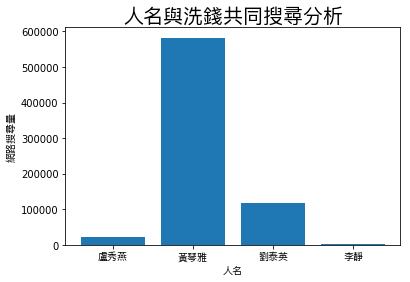

In [19]:
zhfont1 = fm.FontProperties(fname='/System/Library/Fonts/PingFang.ttc') 
key_name = ["盧秀燕","黃琴雅","劉泰英","李靜"]
x = [0,1,2,3]
x_label = "人名"
y_label = "網路搜尋量"
ax = plt.bar(key_name,Search_amount_0.values())
plt.xticks(x, key_name,fontproperties=zhfont1)
plt.title("人名與洗錢共同搜尋分析",fontproperties=zhfont1,fontsize = 20)
plt.xlabel(x_label,fontproperties=zhfont1)
plt.ylabel(y_label,fontproperties=zhfont1)


Text(0,0.5,'網路搜尋量')

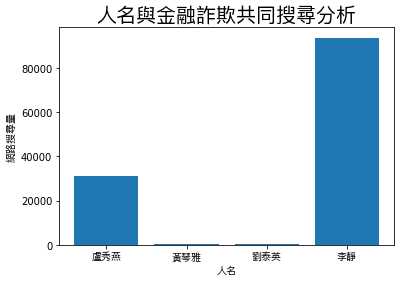

In [20]:
x = [0,1,2,3]
x_label = "人名"
y_label = "網路搜尋量"
bx = plt.bar(key_name,Search_amount_1.values())
plt.xticks(x, key_name,fontproperties=zhfont1)
plt.title("人名與金融詐欺共同搜尋分析",fontproperties=zhfont1,fontsize = 20)
plt.xlabel(x_label,fontproperties=zhfont1)
plt.ylabel(y_label,fontproperties=zhfont1)